In [1]:
import pandas as pd
from PIL import Image
import io
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torchvision.transforms import ToTensor, Resize
from torchvision import transforms


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
if torch.cuda.is_available():
  torch.set_default_device('cuda')
  device = 'cuda'
else:
  device = 'cpu'

In [2]:
cntry_str =  np.load('cntry_str.npy', allow_pickle=True)
test = ['AE','NO','AE','CO','AD', 'NO']
np.searchsorted(cntry_str, test)

array([ 1, 39,  1, 13,  0, 39], dtype=int64)

In [3]:
fromfile = False
if fromfile:
    df = pd.read_parquet('data', engine='fastparquet')
    shuffled_df = df[['image.bytes', 'country_iso_alpha2']].sample(frac=1)
    shuffled_df.to_parquet('shuffled_data.parquet')
df = pd.read_parquet('shuffled_data.parquet', engine='fastparquet')
rows = df.shape[0]

In [4]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(io.BytesIO(row['image.bytes']))
        
        if self.transforms:
            image = self.transforms(image)
        return image.to(device), np.searchsorted(cntry_str, row['country_iso_alpha2'])

In [5]:
ds = ImageDataset(df, transforms.Compose([transforms.Resize(128), transforms.ToTensor()]))
dl = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=0)

('NO', torch.Size([3, 128, 691]))

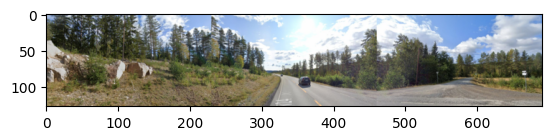

In [6]:
i = 202
im, lab = ds.__getitem__(i)
plt.imshow(im.to('cpu').transpose(0,2).transpose(0,1))
cntry_str[lab], im.shape

In [7]:
im.device

device(type='cuda', index=0)

In [8]:
generator1 = torch.Generator('cuda').manual_seed(42)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(ds, [0.6, 0.3, 0.1], generator=generator1)

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, num_workers=0)

In [10]:
len(cntry_str)

56

In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 3, 3)
        self.conv2 = nn.Conv2d(3, 4, 5)
        self.conv3 = nn.Conv2d(4, 8, 5)
        self.conv4 = nn.Conv2d(8, 8, 5)

        self.fc1 = nn.Linear(1248, 600)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 56)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_loss(self, x):
      self.train()
      return self.loss_fn(self(x[0]), x[1])
    
    @torch.no_grad()
    def calc_loss(self, dataloader):
      self.eval()
      total_loss = 0.0
      i = 0
      for inputs, targets in dataloader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = self(inputs)
          loss = self.loss_fn(outputs, targets)
          total_loss += loss.item()
          i += 1
          if i > 10:
             break
          
      return total_loss / i #len(dataloader)

In [12]:
model = Model().to(device)

total_params = sum(
	param.numel() for param in model.parameters()
)
print(total_params)

831100


In [13]:
optimizer = optim.AdamW(model.parameters())

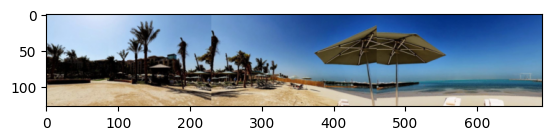

In [14]:
for i, iter in enumerate(train_dataloader):
        plt.imshow(iter[0][0].to('cpu').transpose(0,2).transpose(0,1))
        break

In [15]:

# költségek tárolása, hogy tudjuk majd őket ábrázolni
tr_losses = []
val_losses = []


# tanítás
for epoch in range(10):
  for i, iter in enumerate(train_dataloader):
      
      # train mode, gradiensek nullázása
      model.train()
      optimizer.zero_grad()

      # backprop, param update
      train_loss = model.get_loss(iter)
      train_loss.backward()
      optimizer.step()

      if i % 20 == 0:
        tr_losses.append(train_loss.item())
        val_loss = model.calc_loss(val_dataloader)
        val_losses.append(val_loss)
        print(f"epoch {epoch}, step {i}: train loss {train_loss:.5f}, val loss: {val_loss:.5f}")

#print(f"epochs: {iter+1}, train loss {train_loss:.2f}, val loss: {val_loss:.2f}")

epoch 0, step 0: train loss 4.02343, val loss: 4.02610
epoch 0, step 20: train loss 4.11617, val loss: 4.17614
epoch 0, step 40: train loss 4.15821, val loss: 4.13365
epoch 0, step 60: train loss 4.35184, val loss: 4.09009
epoch 0, step 80: train loss 4.27292, val loss: 4.22930
epoch 0, step 100: train loss 4.22416, val loss: 4.29585
epoch 0, step 120: train loss 4.48231, val loss: 4.10540
epoch 0, step 140: train loss 3.86857, val loss: 4.07937
epoch 0, step 160: train loss 4.45946, val loss: 4.16645
epoch 0, step 180: train loss 4.10160, val loss: 4.23749
epoch 0, step 200: train loss 4.19074, val loss: 4.10077
epoch 0, step 220: train loss 3.94370, val loss: 4.17762
epoch 0, step 240: train loss 4.02983, val loss: 4.15662
epoch 0, step 260: train loss 4.37945, val loss: 4.11508
epoch 0, step 280: train loss 4.08470, val loss: 4.22280
epoch 0, step 300: train loss 4.00867, val loss: 4.03317
epoch 0, step 320: train loss 3.83938, val loss: 4.14020
epoch 0, step 340: train loss 4.00862

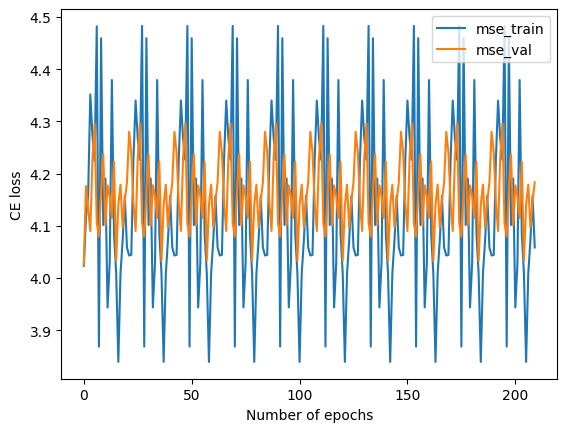

In [16]:
plt.plot(tr_losses, label="mse_train")
plt.plot(val_losses, label="mse_val")
plt.xlabel("Number of epochs")
plt.ylabel("CE loss")
plt.legend()
plt.show()